## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [157]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib qt
%matplotlib inline
np.set_printoptions(threshold=np.inf)

In [158]:
# Define Lane Class
class Line():
    def __init__(self, img_shape):
        # was the line detected in the last iteration?
        self.img_shape = img_shape
        self.detected = False  
        self.n = 5
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients over the last n iterations
        self.fits = [np.array([False])]  
        # last set of coefficients
        self.current_fit = None
        # avg coeffs of last n iterations
        self.avg_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def update_fit(self, x_values, coeffs):
        if self.detected:
            self.recent_xfitted.append(x_values)
            if len(self.recent_xfitted) > self.n:
                self.recent_xfitted = self.recent_xfitted[len(self.recent_xfitted)-self.n:]
            self.bestx = sum(self.recent_xfitted)/len(self.recent_xfitted)
            
            self.current_fit = coeffs
            self.fits.append(coeffs)
            if len(self.fits) > self.n:
                self.fits = self.fits[len(self.fits) - self.n:]
            self.avg_fit = sum(self.fits)/len(self.fits)
    
    def update_radius(self, ym_per_pix=30/720):
        left_fit_cr = self.avg_fit
        y_eval = self.img_shape[0]
        self.radius_of_curvature = (np.power((1+np.power(((2*left_fit_cr[0]*y_eval*ym_per_pix) + left_fit_cr[1]), 2)), 1.5))//np.abs((2*left_fit_cr[0]))
        return self.radius_of_curvature
             


In [176]:
class Camera():
    def __init__(self):
        self.M = None
        self.M_inv = None
        self.img_size = None
        
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        
        self.M = None
        self.Minv = None
    
    def calibrate(self, images, chessboard=(9,6)):
        img = cv2.imread(images[0])
        self.img_size = (img.shape[1], img.shape[0])
        objp = np.zeros((chessboard[1]*chessboard[0],3), np.float32)
        objp[:,:2] = np.mgrid[0:chessboard[0], 0:chessboard[1]].T.reshape(-1,2)
        objpoints = []
        imgpoints = []
        out_imgs = []
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, chessboard, None)
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
                # Draw and display the corners
                #cv2.drawChessboardCorners(img, chessboard, corners, ret)
                out_imgs.append(img)
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, imgpoints, self.img_size,None,None)
        
    def calibrate_perspective(self, img):
        horizon_px = 470
        mid = int(self.img_size[0]/2)
        tl = [mid - 100, horizon_px]
        tr = [mid + 100, horizon_px]
        bl = [200, self.img_size[1]-25]
        br = [1100, self.img_size[1]-25]
        src = np.float32([tl, tr, bl, br])
        
        color = (0, 255, 0) 
        thickness = 9
        oimg = np.array(img, copy=True)
        cv2.line(oimg, tuple(tl), tuple(tr), color, thickness) 
        cv2.line(oimg, tuple(tr), tuple(br), color, thickness) 
        cv2.line(oimg, tuple(br), tuple(bl), color, thickness) 
        cv2.line(oimg, tuple(bl), tuple(tl), color, thickness) 
 
        dst = np.float32([[200,100],[self.img_size[0] - 200,100],[200,self.img_size[1]],[self.img_size[0] - 200,self.img_size[1]]])
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        return oimg
    
    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):

        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
        grad_dir = np.arctan2(abs_sobely, abs_sobelx)
        # 5) Create a binary mask where direction thresholds are met
        binary = np.zeros_like(grad_dir)
        binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
        # 6) Return this mask as your binary_output image
        return binary
    
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
    
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Calculate the magnitude 
        sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
        # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
        # 5) Create a binary mask where mag thresholds are met
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
        # 6) Return this mask as your binary_output image
        return binary
    
    def hls_select(self, img, thresh=(0, 255)):
        # 1) Convert to HLS color space
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]
        # 2) Apply a threshold to the S channel
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
        # 3) Return a binary image of threshold result
        return binary
    
    def pipeline(self, img, s_thresh=(170, 255), sx_thresh=(20, 100)):
        img = np.copy(img)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        
        range_min = 850
        range_max = 950
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        return color_binary, s_binary, sxbinary, l_channel
     
    def undistort_image(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def transform_image(self, img):
        return cv2.warpPerspective(img, self.M, self.img_size, flags=cv2.INTER_LINEAR)
        
    def get_top_down(self, img):
        return self.transform_image(self.undistort_image(img))
    
    def display_lane(self, binary_img, original_img):

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        img_shape = gray_img.shape
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        pts_left = np.array([np.transpose(np.vstack([left_lane.bestx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        print(np.int_([pts]).shape)
        print(color_warp.shape)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, camera.Minv, (original_img.shape[1], gray_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        return result
        

# 1. Calibrate Camera 

Text(0.5, 1.0, 'Undistorted Image')

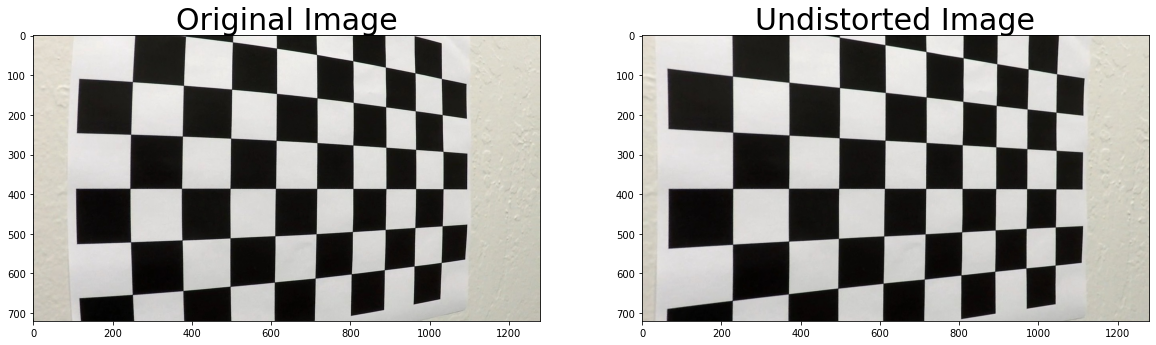

In [177]:

images = glob.glob('../camera_cal/calibration*.jpg')
camera = Camera()
camera.calibrate(images)
test_img = plt.imread(images[0])
undst = camera.undistort_image(test_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)


# 2. Perspective Transform

Text(0.5, 1.0, 'Transformed Image')

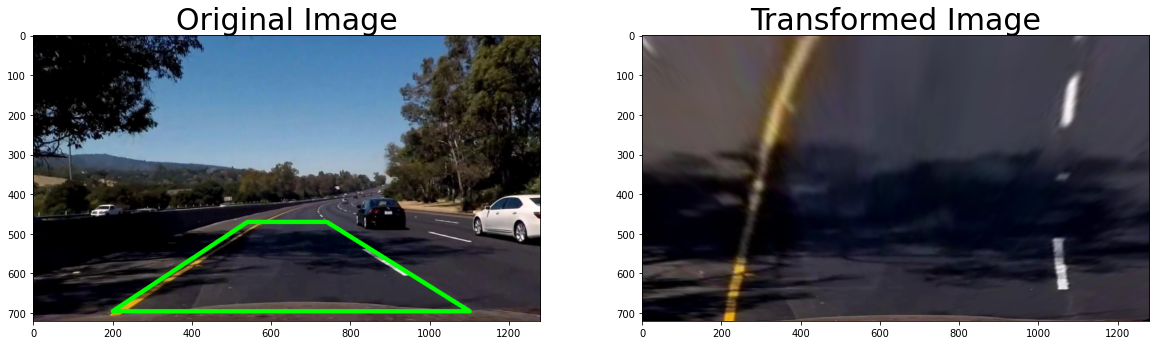

In [178]:
fname = '../test_images/shadow1.jpg'
img = plt.imread(fname)
cal_img = camera.undistort_image(img)
outimg = camera.calibrate_perspective(cal_img)
tximg = camera.transform_image(cal_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(outimg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(tximg)
ax2.set_title('Transformed Image', fontsize=30)

# 3. Tune the filtered image

In [182]:
def plot_images(s_thresh_min, s_thresh_max, sx_thresh_min, sx_thresh_max):
    # Plot the result
    result, s, sx, L = camera.pipeline(tximg, s_thresh=(s_thresh_min, s_thresh_max), sx_thresh=(sx_thresh_min, sx_thresh_max))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(s)
    ax1.set_title('s', fontsize=40)

    ax2.imshow(tximg)
    ax2.set_title('Input', fontsize=40)
    
    ax3.imshow(sx)
    ax3.set_title('sx', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

s_thresh_min = widgets.IntSlider(min=0,max=255,step=1,value=90, continuous_update=False, description='s_min')
s_thresh_max = widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description='s_max')
sx_thresh_min = widgets.IntSlider(min=0,max=255,step=1,value=5, continuous_update=False, description='sx_min')
sx_thresh_max = widgets.IntSlider(min=0,max=255,step=1,value=100, continuous_update=False, description='sx_max')
ui = widgets.HBox([s_thresh_min, s_thresh_max, sx_thresh_min, sx_thresh_max])

out = widgets.interactive_output(plot_images, {'s_thresh_min': s_thresh_min, 's_thresh_max': s_thresh_max, 'sx_thresh_min': sx_thresh_min, 'sx_thresh_max': sx_thresh_max})

display(ui, out)  

Output()

(720, 1280)


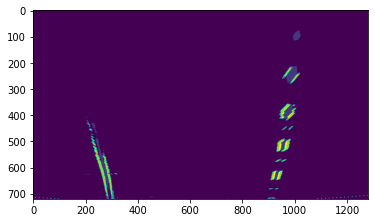

In [78]:
# Test camera pipeline
result, s, sx = camera.pipeline(tximg)
binary_img = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
plt.imshow(binary_img)
print(binary_img.shape)

# 5. Detect Lane Pixels & Find Line

starting lane find


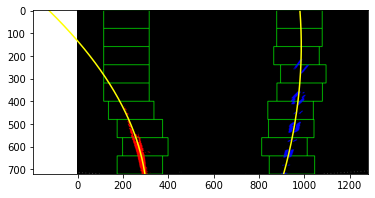

In [61]:
def start_lane_find(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        
        good_left_inds = ((nonzerox < win_xleft_high) & (nonzerox > win_xleft_low) 
                                  & (nonzeroy < win_y_high) & (nonzeroy > win_y_low)).nonzero()[0]
        good_right_inds = ((nonzerox < win_xright_high) & (nonzerox > win_xright_low) 
                                  & (nonzeroy < win_y_high) & (nonzeroy > win_y_low)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if good_left_inds.shape[0] > minpix:
            histogram = np.sum(binary_warped[(nwindows-(window+1))*window_height:(nwindows-window)*window_height, win_xleft_low:win_xleft_high], axis=0)
            leftx_current = np.argmax(histogram) + win_xleft_low
        if good_right_inds.shape[0] > minpix:
            histogram = np.sum(binary_warped[(nwindows-(window+1))*window_height:(nwindows-window)*window_height, win_xright_low:win_xright_high], axis=0)
            rightx_current = np.argmax(histogram) + win_xright_low

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError as e:
        # Avoids an error if the above is not implemented fully
        print(e)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Color detected pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    plt.plot(left_lane.bestx, ploty, color='yellow')
    plt.plot(right_lane.bestx, ploty, color='yellow')
    
    return out_img

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###

    # USING PREV not AVG
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    left_fit_old = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_fit_old = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = ((nonzerox < left_fit_old+margin) & (nonzerox > left_fit_old-margin)).nonzero()[0]
    right_lane_inds = ((nonzerox < right_fit_old+margin) & (nonzerox > right_fit_old-margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, deg=2)
    right_fit = np.polyfit(righty, rightx, deg=2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        left_lane.detected = False
        right_lane.detected = False
    else:
        left_lane.detected = True
        right_lane.detected = True
        left_lane.update_fit(left_fitx, left_fit)
        right_lane.update_fit(right_fitx, right_fit)
        
    return left_fitx, right_fitx, ploty

def get_lines(img):
    binary_warped = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find our lane pixels first
    if not left_lane.detected or not right_lane.detected:
        print('starting lane find')
        out_img = start_lane_find(binary_warped)
    else:
        print('using line margin finding')
        out_img = search_around_poly(binary_warped)
    
    return out_img

#binary_warped = plt.imread('warped-example.jpg')
left_lane = Line(binary_img.shape)
right_lane = Line(binary_img.shape)

out_img = get_lines(binary_img)

plt.imshow(out_img)

using line margin finding


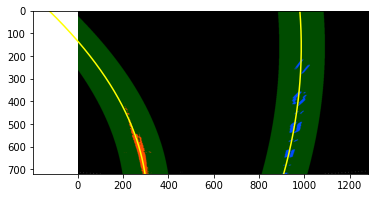

In [62]:
out_img = get_lines(binary_img)

plt.imshow(out_img)

# Flow
- Create 2 lane line objects
- Fit image w/ bucketing technique
- store polynomials to avg
- switch to poly match technique
- if not found
- 

### Helper functions
- Search around poly
    - Take 'line object
    - Use prev or avg, draw margin, find points in that area, attempt to get fit for poly
    - if no points found, return w/ failure
    - if points found,
        - Draw line
        - Draw margin
        - update line object with all new data

- Start lane find
    - Does not use average, finds points from left/right half of image
    - Draw rectangles, find points, attempt to fit poly
    - if no points found, return with failure
    - if points found
        - draw line
        - update line object

each helper function 

# 6. Determine Curvature & Vehicle Position

In [63]:
def get_vehicle_lane_position(img, left_lane, right_lane, px_to_m=3.7/700):
    center = left_lane.bestx[-1] + ((right_lane.bestx[-1] - left_lane.bestx[-1])/2)
    veh_pos = img.shape[1]/2
    return px_to_m*(veh_pos - center)



print('Vehicle center: ', get_vehicle_lane_position(out_img, left_lane, right_lane))
print('Left radius:', left_lane.update_radius(), 'm')
print('Right radisu:', right_lane.update_radius(), 'm')

Vehicle center:  0.19848488601976608
Left radius: 2125.0 m
Right radisu: 3062.0 m


# 7. Display (unwarp) curves to image

(1, 1, 1440, 2)
(720, 1280, 3)


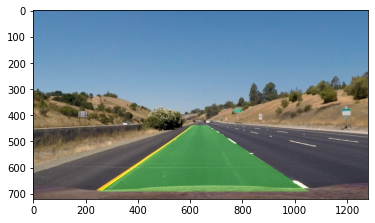

In [64]:

    
    
result = camera.display_lane(binary_img, img)
plt.imshow(result)

# 8. Output Image, Curvature, and Position

In [ ]:
# plt.imshow()